-------
- # CNN
    - 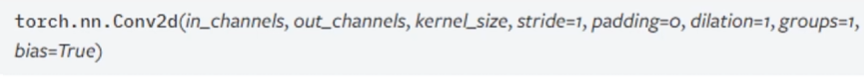
    - 형태
    - Visdom
    - custom dataset
        - transforms.Compose
        - torchvision.datasets.ImageFolder
    - torch.save(net.state_dict(), "./model/model.pth")
    - new_net = CNN().to(device)
    - new_net.load_state_dict(torch.load('./model/model.pth'))
-------

# CNN

## 전처리


In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(888)
if device == 'cuda':
    torch.cuda.manual_seed_all(888)
    

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 165kB/s]
 18%|█▊        | 295k/1.65M [00:00<00:03, 438kB/s] 


KeyboardInterrupt: 

In [ ]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [ ]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

## CNN 모델 생성
- 레이어 별로 생성되는 과정 주시
    - sequential 활용해서 레이어 별로 코딩하고있음
    - 데이터 크기 변화 눈여겨볼것


In [ ]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(3*3 * 128, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten them for FC
        out = self.fc(out)
        return out

- 

In [ ]:
# instantiate CNN model
model = CNN().to(device)

In [ ]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 훈련

In [ ]:
# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.194578141
[Epoch:    2] cost = 0.047204487
[Epoch:    3] cost = 0.0332514457
[Epoch:    4] cost = 0.0267633591
[Epoch:    5] cost = 0.0209419671
[Epoch:    6] cost = 0.0171016604
[Epoch:    7] cost = 0.0139468592
[Epoch:    8] cost = 0.0119210826
[Epoch:    9] cost = 0.0102011152
[Epoch:   10] cost = 0.00867079291
[Epoch:   11] cost = 0.00845651235
[Epoch:   12] cost = 0.00730272522
[Epoch:   13] cost = 0.00559721747
[Epoch:   14] cost = 0.00567895127
[Epoch:   15] cost = 0.00587418489
Learning Finished!


## test

In [ ]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9914000034332275


/opt/conda/lib/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# 커스텀 데이터

## 이미지 전처리
- Compose 를 통해 여러 전처리를 한번에 진행할수 있고,
- transform 을 지정해 로드와 함꼐 전처리가 가능하다

# 10-4 ImageFolder (2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root='./custom_data/train_data', transform=trans)

In [ ]:
data_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True, num_workers=2)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120,2)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)
        out = self.layer3(out)
        return out
        

In [ ]:
#testing 
net = CNN().to(device)
test_input = (torch.Tensor(3,3,64,128)).to(device)
test_out = net(test_input)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().to(device)

In [ ]:
total_batch = len(data_loader)

epochs = 7
for epoch in range(epochs):
    avg_cost = 0.0
    for num, data in enumerate(data_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(imgs)
        loss = loss_func(out, labels)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
        
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
print('Learning Finished!')   

[Epoch:1] cost = 0.654133677482605
[Epoch:2] cost = 0.49326831102371216
[Epoch:3] cost = 0.22222398221492767
[Epoch:4] cost = 0.0660901740193367
[Epoch:5] cost = 0.026237962767481804
[Epoch:6] cost = 0.01393866166472435
[Epoch:7] cost = 0.008723110891878605
Learning Finished!


## 데이터 저장,로드
- 저장 시 state_dict 를 .pth 로 저장
- 로드 시 동일한 크기의 모델에 불러오면 됨


In [ ]:
torch.save(net.state_dict(), "./model/model.pth")

In [ ]:
new_net = CNN().to(device)

In [ ]:
new_net.load_state_dict(torch.load('./model/model.pth'))

<All keys matched successfully>

In [ ]:
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.0913,  0.0032, -0.0172, -0.0214,  0.0930], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.0913,  0.0032, -0.0172, -0.0214,  0.0930], device='cuda:0',
       grad_fn=<SelectBackward0>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]], device='cuda:0')

In [ ]:
trans=torchvision.transforms.Compose([
    transforms.Resize((64,128)),
    transforms.ToTensor()
])
test_data = torchvision.datasets.ImageFolder(root='./custom_data/test_data', transform=trans)

In [ ]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [ ]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

Accuracy: 1.0


In [ ]:
trans = transforms.Compose([
    transforms.Resize((64,128))
])

train_data = torchvision.datasets.ImageFolder(root='custom_data/origin_data', transform=trans)

In [ ]:
for num, value in enumerate(train_data):
    data, label = value
    print(num, data, label)
    
    if(label == 0):
        data.save('custom_data/train_data/gray/%d_%d.jpeg'%(num, label))
    else:
        data.save('custom_data/train_data/red/%d_%d.jpeg'%(num, label))

0 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0E17D811D0> 0
1 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAAA79950> 0
2 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAAA78C50> 0
3 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAAA79290> 0
4 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B7A10> 0
5 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B7CD0> 0
6 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B7DD0> 0
7 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B4BD0> 0
8 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B6690> 0
9 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B5490> 0
10 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B6690> 0
11 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B6F90> 0
12 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B6690> 0
13 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA8B4ED0> 0
14 <PIL.Image.Image image mode=RGB size=128x64 at 0x7F0EAA